In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/rajeckidoyle/miniconda3/envs/my_torch_geometric/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Import Dataset

In [2]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_reverse_split_{split}.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [3]:
train_dataset = FingerprintDataset(split='train')
test_dataset = FingerprintDataset(split='test')

In [4]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config

no_of_epochs = best_config.GLOBALPARAMETERS['no_of_epochs']

In [6]:
#Get Model Parameters
hyperparameters = best_config.MLP_QR_HYPERPARAMETERS

model_params = hyperparameters
model_params['feature_size'] = train_dataset.x.shape[1]

## Define Model

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
model_params

{'has_edge_info': False,
 'batch_size': 16,
 'learning_rate': 4.15e-05,
 'model_layers': 4,
 'model_embedding_size': 64,
 'model_dense_neurons': 256,
 'model_linear_dropout_rate': 0.0805,
 'model_embedding_dropout_rate': 0.0144,
 'feature_size': 1024}

In [9]:
import models
print("Loading model...")

#Create instance of model
model = eval('models.'+'MLP_QR'+'(model_params)')
print(model)
print(count_parameters(model))

Loading model...
MLP_QR(
  (conv_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (initial_conv): Linear(in_features=1024, out_features=64, bias=True)
  (embedding_dropout): Dropout(p=0.0144, inplace=False)
  (linear_dropout): Dropout(p=0.0805, inplace=False)
  (readout1): Linear(in_features=64, out_features=256, bias=True)
  (lower_quantile): Linear(in_features=256, out_features=1, bias=True)
  (readout2): Linear(in_features=64, out_features=256, bias=True)
  (median): Linear(in_features=256, out_features=1, bias=True)
  (readout3): Line

In [10]:
model = model.to(device)

In [11]:
from torch.utils.data import DataLoader

# Root mean squared error
loss_fn = torch.nn.MSELoss()

NUM_FINGERPRINTS_PER_BATCH = 64
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

In [12]:
def quantile_loss(preds, target, quantiles=[0.05, 0.5, 0.95]):
    """ aka Pinball loss """
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - torch.unsqueeze(preds[:, i], 1)
        q_loss = torch.max((q-1) * errors, q * errors)
        losses.append(q_loss)
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

## Training Loop

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])  

loss_fn = quantile_loss

print("Starting training...")
for epoch in range(300):
    train_batch_loss = 0
    #train loop          
    for j, (fingerprint, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        preds = model(fingerprint)
        loss = loss_fn(preds, labels)
        train_batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_batch_loss / len(train_loader)

    valid_batch_loss = 0
    #train loop
    with torch.no_grad(): 
        for j, (fingerprint, labels) in enumerate(test_loader):
            fingerprint = fingerprint.to(device)
            labels = labels.to(device)
            preds = model(fingerprint)
            loss = loss_fn(preds, labels)
            valid_batch_loss += loss.item()
        val_loss = valid_batch_loss / len(test_loader)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {train_loss}| {val_loss}")

Starting training...
Epoch 0 | Train Loss 9.808944902921978| 9.497723960876465
Epoch 10 | Train Loss 9.362411950763903| 9.031668281555175
Epoch 20 | Train Loss 8.514914663214432| 8.154460144042968
Epoch 30 | Train Loss 7.108101844787598| 6.712008476257324
Epoch 40 | Train Loss 5.3741811451159025| 5.121512794494629
Epoch 50 | Train Loss 3.827761562247025| 3.736953020095825
Epoch 60 | Train Loss 2.88042005739714| 2.7716625213623045
Epoch 70 | Train Loss 2.3305984484521964| 2.1166940689086915
Epoch 80 | Train Loss 1.8362452356438888| 1.9600151300430297
Epoch 90 | Train Loss 1.5420246375234503| 1.5344170570373534
Epoch 100 | Train Loss 1.4520740697258396| 1.358454155921936
Epoch 110 | Train Loss 1.2840463299500315| 1.288280439376831
Epoch 120 | Train Loss 1.2634010628650063| 1.4348886013031006
Epoch 130 | Train Loss 1.2091978474667198| 1.282157874107361
Epoch 140 | Train Loss 1.1073348679040607| 1.157457995414734
Epoch 150 | Train Loss 1.1372766055558856| 1.0911173582077027
Epoch 160 | Tra

## Evaluate on the Test Set

In [14]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame({
      "lower": [],
      "y_pred": [],
      "upper": [],
      'y_real':[],
      })

model.eval()
with torch.no_grad():
    test_batch_loss = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
       
        preds = model(fingerprint)
        
        preds = preds.cpu()
        labels = labels.cpu()

        preds = preds.detach().numpy()
        labels = labels.detach().numpy()

        y_vals = [preds[:, 1], preds[:, 0], preds[:, 2], labels]
        data = {
            "lower": list(y_vals[1].squeeze()),
            "y_pred": list(y_vals[0].squeeze()),
            "upper": list(y_vals[2].squeeze()),
            'y_real': list(y_vals[3].squeeze())
            }
        data = pd.DataFrame(data)
        df = df.append(pd.DataFrame(data))
df = df.sort_values('y_pred').reset_index(drop=True)
df

,lower,y_pred,upper,y_real
0,1.922858,3.378607,4.904815,3.370590
1,2.287731,3.487109,4.780229,4.142667
2,2.792235,3.970536,5.042840,3.113509
3,2.899563,4.019099,5.014515,3.767004
4,2.477771,4.024013,6.334627,4.060481
...,...,...,...,...
298,6.934367,8.103345,10.144323,8.677781
299,7.105079,8.238912,10.344212,7.356547
300,7.068158,8.299573,10.661925,8.080922
301,5.679439,8.407451,15.126530,8.301030


In [21]:
df.to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/datasets/QR.csv')

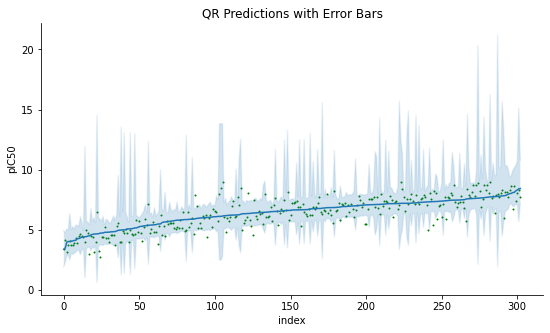

In [15]:
x = df.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
mu = df['y_pred']
lower = df['lower']
upper =  df['upper']

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(x, df['y_real'], label='pred mean', color='g', s=1)
ax.plot(x, mu, label='pred mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('index')
ax.set_ylabel('pIC50')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('QR Predictions with Error Bars')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/QRerrbar.jpeg',bbox_inches='tight',dpi=300)

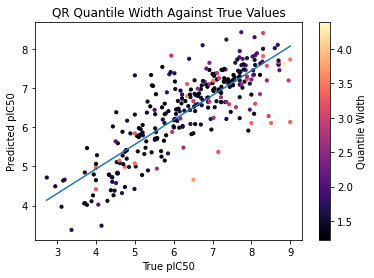

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data...
x = df["y_real"]
y = df["y_pred"]
df['variance'] = df['upper']-df['lower']
color = df['variance']**0.5
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

sc = plt.scatter(x, y, c=color, s=10, cmap='magma')
cbar = plt.colorbar(sc)
cbar.set_label('Quantile Width')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('QR Quantile Width Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/pvtQR.jpeg',bbox_inches='tight',dpi=300)

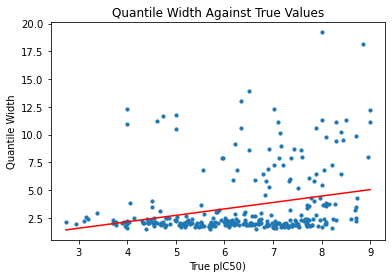

In [17]:
plt.scatter(df['y_real'], df['variance'], s=10)
plt.xlabel('True pIC50)')
plt.ylabel('Quantile Width')
plt.plot(np.unique(df['y_real']), np.poly1d(np.polyfit(df['y_real'], df['variance'], 1))(np.unique(df['y_real'])), c='r')
plt.title('Quantile Width Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/varvtQR.jpeg',bbox_inches='tight',dpi=300)

In [18]:
from sklearn import metrics
from scipy.stats import stats
def get_results(df):
    mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
    sc = stats.spearmanr(df["y_real"],df["y_pred"])[0]
    pc = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
    r = metrics.r2_score(df["y_real"],df["y_pred"])
    varcorr = np.corrcoef(df['y_real'], df['variance'])[0,1]

    results = {
        'Mean Square Error':mse,
        'Spearman':sc,
        'Pearson':pc,
        'R':r,
        'Variance Rho': varcorr,
    }
    results_df = pd.DataFrame([results])
    return results_df

get_results(df).to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/ground_truth/QRresults.csv')

In [19]:
get_results(df)

,Mean Square Error,Spearman,Pearson,R,Variance Rho
0,0.613865,0.802621,0.826627,0.677205,0.264245
